## 1. Introdução
Implementaremos a regressão linear utilizando a biblioteca autograd para calcular os gradientes.



Eu gostaria de prever o comportamento da ação PETR4 porque isso permite realizar operações lucrativas com antecedência

## 2. Coleta de Dados

In [52]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad

# Definir o ticker da ação PETR4 e coletar dados históricos
ticker = 'PETR4.SA'
dados = yf.download(ticker, start="2020-01-01", end="2023-01-01")

# Exibir as primeiras linhas dos dados
dados.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2020-01-02 00:00:00+00:00,10.621439,30.700001,30.700001,30.309999,30.510000,37774500
2020-01-03 00:00:00+00:00,10.534945,30.450001,31.240000,30.450001,30.879999,71595600
2020-01-06 00:00:00+00:00,10.659495,30.809999,30.940001,29.950001,30.430000,81844000
2020-01-07 00:00:00+00:00,10.617978,30.690001,30.879999,30.469999,30.820000,32822000
2020-01-08 00:00:00+00:00,10.552243,30.500000,30.770000,30.240000,30.690001,48215600


## 3. Análise e Pré-processamento dos Dados

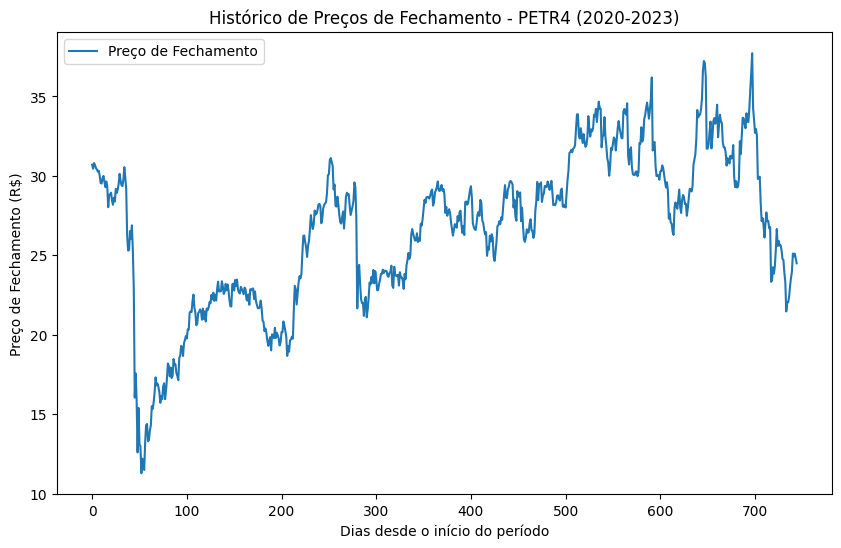

In [53]:
# Vamos focar no preço de fechamento ('Close'), e remover possíveis valores ausentes.
dados = dados[['Close']].dropna()

# Criar uma coluna para representar os dias (como variável independente)
dados['Days'] = range(len(dados))

# Visualizar os dados de fechamento da ação
plt.figure(figsize=(10,6))
plt.plot(dados['Days'], dados['Close'], label='Preço de Fechamento')
plt.title('Histórico de Preços de Fechamento - PETR4 (2020-2023)')
plt.xlabel('Dias desde o início do período')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.show()


## 4. Divisão dos Dados em Treino e Teste

In [54]:
# Função para criar janelas deslizantes (k últimas observações como entrada)
def criar_janelas_deslizantes(dados, k):
    X, y = [], []
    for i in range(len(dados) - k):
        X.append(dados[i:i + k])  # Entradas: últimas k observações
        y.append(dados[i + k])    # Saída: próxima observação
    return np.asarray(X), np.asarray(y)

# Definir o número de valores anteriores (k) para prever o próximo valor
k = 3  # Exemplo: usar os últimos 3 valores para prever o próximo

# Criar janelas deslizantes a partir dos dados de fechamento
X, y = criar_janelas_deslizantes(dados['Close'].values, k)

# Dividir os dados em treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## 5. Implementação da Regressão Linear com autograd

In [55]:

# Função de modelo linear corrigida
def modelo_linear(params, X):
    W, b = params
    return np.dot(X, W) + b  # Aqui X é (n x k) e W é (k,)

# Função de custo
def custo(params, X, y):
    previsao = modelo_linear(params, X)
    erro = previsao - y
    return np.mean(erro**2)

# Gradiente da função de custo
grad_custo = grad(custo)

# Verificando a forma de X_train e removendo a dimensão extra
print(f"Forma original de X_train: {X_train.shape}")
X_train = np.squeeze(X_train)  # Remover a terceira dimensão
print(f"Nova forma de X_train: {X_train.shape}")

# Gradientes e inicialização
n_caracteristicas = X_train.shape[1]  # X_train tem dimensão (n x k)
W = np.random.randn(n_caracteristicas)  # W deve ter dimensão (k,)
b = np.random.randn(1)  # b continua sendo um escalar
params = [W, b]

# Treinamento
taxa_aprendizado = 0.001
n_iteracoes = 100000  # Reduzindo para 100k

print("X_train primeiro exemplo:", X_train[0])
print("y_train primeiro exemplo:", y_train[0])

for i in range(n_iteracoes):
    gradientes = grad_custo(params, X_train, y_train)
    params[0] -= taxa_aprendizado * gradientes[0]  # Atualizar W
    params[1] -= taxa_aprendizado * gradientes[1]  # Atualizar b
    if i % 1000 == 0:  # Verificando custo a cada 1000 iterações
        print(f"Iteração {i}: Custo = {custo(params, X_train, y_train)}")

Forma original de X_train: (519, 3, 1)
Nova forma de X_train: (519, 3)
X_train primeiro exemplo: [30.70000076 30.45000076 30.80999947]
y_train primeiro exemplo: [30.69000053]


ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

## 6. Avaliação do Modelo

In [76]:
# Fazer previsões no conjunto de teste
y_pred = modelo_linear(params, X_test)

# Erro Médio Absoluto (MAE) e Erro Quadrático Médio (MSE)
mae = np.mean(np.abs(y_test - y_pred))
mse = np.mean((y_test - y_pred)**2)

print(f"Erro Médio Absoluto (MAE): {mae:.2f}")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")

Erro Médio Absoluto (MAE): 11.27
Erro Quadrático Médio (MSE): 162.81


## 7. Visualização dos Resultados

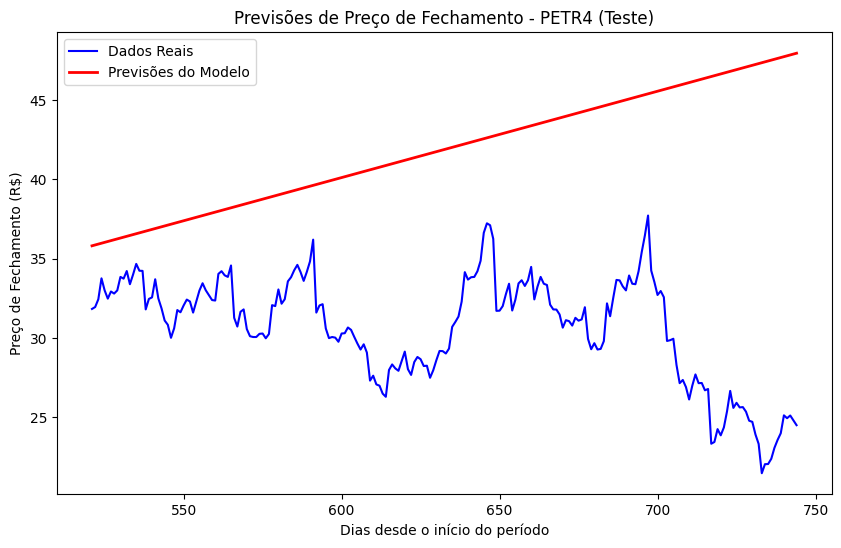

In [77]:
# Plotar as previsões do modelo comparando com os dados reais
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Dados Reais')
plt.plot(range(len(y_pred)), y_pred, color='red', linewidth=2, label='Previsões do Modelo')
plt.title('Previsões de Preço de Fechamento - PETR4 (Teste)')
plt.xlabel('Dias desde o início do período')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.show()


## 8. Conclusão
Usamos o autograd para treinar um modelo de regressão linear e prever os preços de fechamento da PETR4.